# Interpretability pipeline development

We sketch and explore here the design of a pipeline to capture and analyze xAI in NCO.

In [1]:
import os
from pathlib import Path
from typing import List
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy

import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients, DeepLift

import logomaker

import NegativeClassOptimization.config as config
import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.preprocessing as preprocessing
from NegativeClassOptimization import ml
from NegativeClassOptimization import datasets, pipelines, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
# TODO

# # Load from mlflow
# # Add ratios! of pos/neg
# # Add open set examples?

experiment_id = "11"
# run_name = "test"
run_id = "da83601c9a144786b1e324420be94a40"

# api = utils.MlflowAPI()
# r = api.mlflow_request(experiment_id, run_name)
# df = api.build_mlflow_results_df()
# df.head()

# # import requests

# # requests.get(
# #     "http://10.40.3.22:5000/api/2.0/mlflow/artifacts/list",
# #     json={
# #         "run_id": "73a53fc4c0c74e7eababe4f1737cea0b",
# #     },
# #     ).json()
# # # ftp_url = "ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/dataset/train_dataset.tsv/c35495f4_train_dataset.tsv"

# # # from urllib import request
# # # request.urlretrieve(ftp_url, filename=str("test.tsv"))

df_train_path = f"../data/nco_mlflow_runs/ftp/artifacts_store/11/{run_id}/artifacts/dataset/train_dataset.tsv/64e03d8c_train_dataset.tsv"
df_test_path = f"../data/nco_mlflow_runs/ftp/artifacts_store/11/{run_id}/artifacts/dataset/test_dataset.tsv/64e03d8c_test_dataset.tsv"
model_path = f"../data/nco_mlflow_runs/ftp/artifacts_store/11/{run_id}/artifacts/models"

1. Define and preprocess relevant pipeline inputs

In [3]:
ag_pos = "3VRL"
ag_neg = "1NSN"
df_para = utils.load_paratopes()

df = utils.load_global_dataframe()
df_train = pd.read_csv(df_train_path, sep="\t")
df_test = pd.read_csv(df_test_path, sep="\t")

epochs = [0, 1, 9, 19, 29, 39, 49]
models = {}
attributors = {}
for i in epochs:
    models[i] = torch.load(Path(model_path) / f"trained_model_epoch_{i}/data/model.pth")
    attributors[i] = attributor = ml.Attributor(models[i],
        type="deep_lift", 
        baseline_type="shuffle",
        compute_on="logits",
        multiply_by_inputs=True,
    )

In [4]:
slide = "IRGIMVITALF"  # good example, strong +
# slide = "VDDYDVAWFAY"  # strong -
row = df_train[df_train["Slide"] == slide].iloc[0]
row

Slide                                                             IRGIMVITALF
binds_a_pos_ag                                                              1
Slide_farmhash_mod_32768                                                  790
Slide_onehot                [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. ...
X                           [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. ...
y                                                                           1
Name: 44533, dtype: object

In [5]:
res = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for epoch in epochs:
        
        # Adaptor block
        row = df_train[df_train["Slide"] == slide]
        assert row.shape[0] == 1
        row = row.iloc[0]
        
        model = models[epoch]
        attributor = attributors[epoch]
        # 

        # Code adapted from nb 07b, row extracted differently, rest almost same
        binds_a_pos_ag = row["binds_a_pos_ag"]

        # Model predictions and basic parameters
        is_slide_in_train = slide in df_train["Slide"]
        enc = torch.tensor(preprocessing.onehot_encode(slide)).float().reshape((1, -1))
        expits, logits = model.forward(enc, return_logits=True)
        y_pred = expits.round()
        y_true = binds_a_pos_ag
        is_pred_correct = bool((y_pred == y_true)[0][0])
        # print(f"{y_pred=} ? {y_true=} => {is_pred_correct=}")

        # Attributions
        res_attr = {}
        attributions, baseline = attributor.attribute(enc, return_baseline=True)
        baseline_expits, baseline_logits = model.forward(baseline, return_logits=True)
        res_attr["attributor"] = {
            "attributions": attributions,
            "baseline": baseline,
            "baseline_logits": baseline_logits,
            "baseline_expits": baseline_expits,
        }

        # Record results
        res[epoch] = {
            "slide": slide,
            "epoch": epoch,
            "enc": enc,
            "logits": logits,
            "expits": expits,
            "y_pred": y_pred,
            "y_true": y_true,
            "is_pred_correct": is_pred_correct,
            "attributions": res_attr,
        }


# Transform results into a dataframe
df = pd.DataFrame.from_dict(res, orient="index")
df = df.sort_values("logits", ascending=False)
df.reset_index(inplace=True)
24,

df.sort_values("epoch", ascending=True, inplace=True)
df.head()

,index,slide,epoch,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions
6,0,IRGIMVITALF,0,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(6.6094, grad_fn=<UnbindBackward0>)]]","[[tensor(0.9987, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,{'attributor': {'attributions': [tensor([ 9.65...
3,1,IRGIMVITALF,1,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(9.1046, grad_fn=<UnbindBackward0>)]]","[[tensor(0.9999, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,{'attributor': {'attributions': [tensor([ 1.24...
0,9,IRGIMVITALF,9,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(10.2956, grad_fn=<UnbindBackward0>)]]","[[tensor(1.0000, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,{'attributor': {'attributions': [tensor([ 0.11...
5,19,IRGIMVITALF,19,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(8.1545, grad_fn=<UnbindBackward0>)]]","[[tensor(0.9997, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,{'attributor': {'attributions': [tensor([ 0.11...
4,29,IRGIMVITALF,29,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(8.8516, grad_fn=<UnbindBackward0>)]]","[[tensor(0.9999, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,{'attributor': {'attributions': [tensor([ 0.06...


In [9]:
def filter_res_for_selected_attributor(df: pd.DataFrame, attributor_sel: str):
    """Filter df for selected attributor.
    Returns:
        - df_sel: df with selected attributor (Num_slides x #cols(df))
        - df_attr: df with attributions per slide (Num_slides x 220)
    """
    records = []
    for row in df.iterrows():
        s = row[1]
        attr_data = s["attributions"][attributor_sel]
        new_row_dict = {
            **dict(s),
            **attr_data,
        }
        records.append(new_row_dict)

    df_sel = pd.DataFrame.from_records(records)
    df_sel["baseline_logits"] = df_sel["baseline_logits"].astype(float)
    df_sel["baseline_expits"] = df_sel["baseline_expits"].astype(float)
    # df_attr = pd.DataFrame(np.concatenate(df_sel["attributions"].map(lambda x: x.detach().numpy()), axis=0))
    
    return df_sel  #, df_attr


def get_df_sel(attributor_sel, df, df_para):
    """Get df_sel for selected attributor."""
    df_sel = filter_res_for_selected_attributor(df, attributor_sel)
    df_sel["Antigen"] = np.where(df_sel["y_true"] == 1, ag_pos, ag_neg)
    df_sel = pd.merge(df_sel, df_para, how="left", left_on=("slide", "Antigen"), right_on=("Slide", "Antigen"))
    return df_sel

## Case studies

For each case, we draw logos:
1. Sequence logo
2. Paratope logo
3. Deeplift with `multiply_by_inputs`
4. Deeplift without `multiply_by_inputs`

We examine 2 slides per each case:
1. Strong positive prediction
2. Strong negative prediction
3. Prediction close to 0

In [10]:
# Create df_sel per attributor
df_sel_1 = get_df_sel("attributor", df, df_para)
df_sel_2 = get_df_sel("attributor", df, df_para)

df_sel_1

,index,slide,epoch,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,baseline_logits,baseline_expits,Antigen,Slide,Label,hotspot_ID,agregatesAGEpitope,agregatesABParatope
0,0,IRGIMVITALF,0,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(6.6094, grad_fn=<UnbindBackward0>)]]","[[tensor(0.9987, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,"[[tensor(0.0965, grad_fn=<UnbindBackward0>), t...","[[tensor(0.1090), tensor(0.), tensor(0.), tens...",1.122388,0.754431,3VRL,IRGIMVITALF,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,I2R1G1I3M3V3I1--A1L2F4*
1,1,IRGIMVITALF,1,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(9.1046, grad_fn=<UnbindBackward0>)]]","[[tensor(0.9999, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,"[[tensor(0.1250, grad_fn=<UnbindBackward0>), t...","[[tensor(0.1040), tensor(0.), tensor(0.), tens...",1.354523,0.794868,3VRL,IRGIMVITALF,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,I2R1G1I3M3V3I1--A1L2F4*
2,9,IRGIMVITALF,9,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(10.2956, grad_fn=<UnbindBackward0>)]]","[[tensor(1.0000, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,"[[tensor(0.1175, grad_fn=<UnbindBackward0>), t...","[[tensor(0.0810), tensor(0.), tensor(0.), tens...",-1.014928,0.266017,3VRL,IRGIMVITALF,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,I2R1G1I3M3V3I1--A1L2F4*
3,19,IRGIMVITALF,19,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(8.1545, grad_fn=<UnbindBackward0>)]]","[[tensor(0.9997, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,"[[tensor(0.1104, grad_fn=<UnbindBackward0>), t...","[[tensor(0.0800), tensor(0.), tensor(0.), tens...",-3.190179,0.039537,3VRL,IRGIMVITALF,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,I2R1G1I3M3V3I1--A1L2F4*
4,29,IRGIMVITALF,29,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(8.8516, grad_fn=<UnbindBackward0>)]]","[[tensor(0.9999, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,"[[tensor(0.0622, grad_fn=<UnbindBackward0>), t...","[[tensor(0.1000), tensor(0.), tensor(0.), tens...",-5.195423,0.005511,3VRL,IRGIMVITALF,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,I2R1G1I3M3V3I1--A1L2F4*
5,39,IRGIMVITALF,39,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(9.5414, grad_fn=<UnbindBackward0>)]]","[[tensor(0.9999, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,"[[tensor(0.0535, grad_fn=<UnbindBackward0>), t...","[[tensor(0.0860), tensor(0.), tensor(0.), tens...",-7.097262,0.000827,3VRL,IRGIMVITALF,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,I2R1G1I3M3V3I1--A1L2F4*
6,49,IRGIMVITALF,49,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(9.8768, grad_fn=<UnbindBackward0>)]]","[[tensor(0.9999, grad_fn=<UnbindBackward0>)]]","[[tensor(1., grad_fn=<UnbindBackward0>)]]",1,True,"[[tensor(0.0557, grad_fn=<UnbindBackward0>), t...","[[tensor(0.0950), tensor(0.), tensor(0.), tens...",-8.493163,0.000205,3VRL,IRGIMVITALF,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,I2R1G1I3M3V3I1--A1L2F4*


<AxesSubplot: xlabel='epoch', ylabel='logits'>

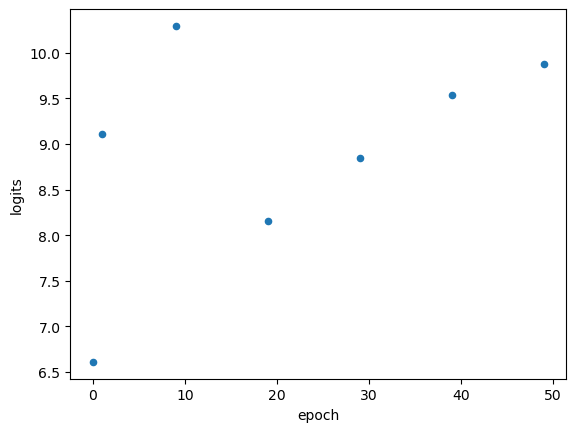

In [11]:
df_sel_1.plot.scatter(x="epoch", y="logits")

In [12]:
def plot_attribution_report_by_index(idx_1, df_sel_1, ax, title):
    row_sel_1_idx_1 = df_sel_1.iloc[idx_1]

    print(row_sel_1_idx_1['slide'])
    ## Attributions: Deeplift w/ multiply by input
    visualisations.plot_logo(
        pd.DataFrame(
            row_sel_1_idx_1["attributions"].detach().numpy().reshape((-1, 20)), 
            columns=config.AMINOACID_ALPHABET
            ),
        ax=ax,
    )
    ax.set_title(title)

In [25]:
row_sel_1_idx_1

index                                                                  1
slide                                                        IRGIMVITALF
epoch                                                                  1
enc                    [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
logits                     [[tensor(9.1046, grad_fn=<UnbindBackward0>)]]
expits                     [[tensor(0.9999, grad_fn=<UnbindBackward0>)]]
y_pred                         [[tensor(1., grad_fn=<UnbindBackward0>)]]
y_true                                                                 1
is_pred_correct                                                     True
attributions           [[tensor(0.1250, grad_fn=<UnbindBackward0>), t...
baseline               [[tensor(0.1040), tensor(0.), tensor(0.), tens...
baseline_logits                                                 1.354523
baseline_expits                                                 0.794868
Antigen                                            

1
IRGIMVITALF
19
IRGIMVITALF
49
IRGIMVITALF


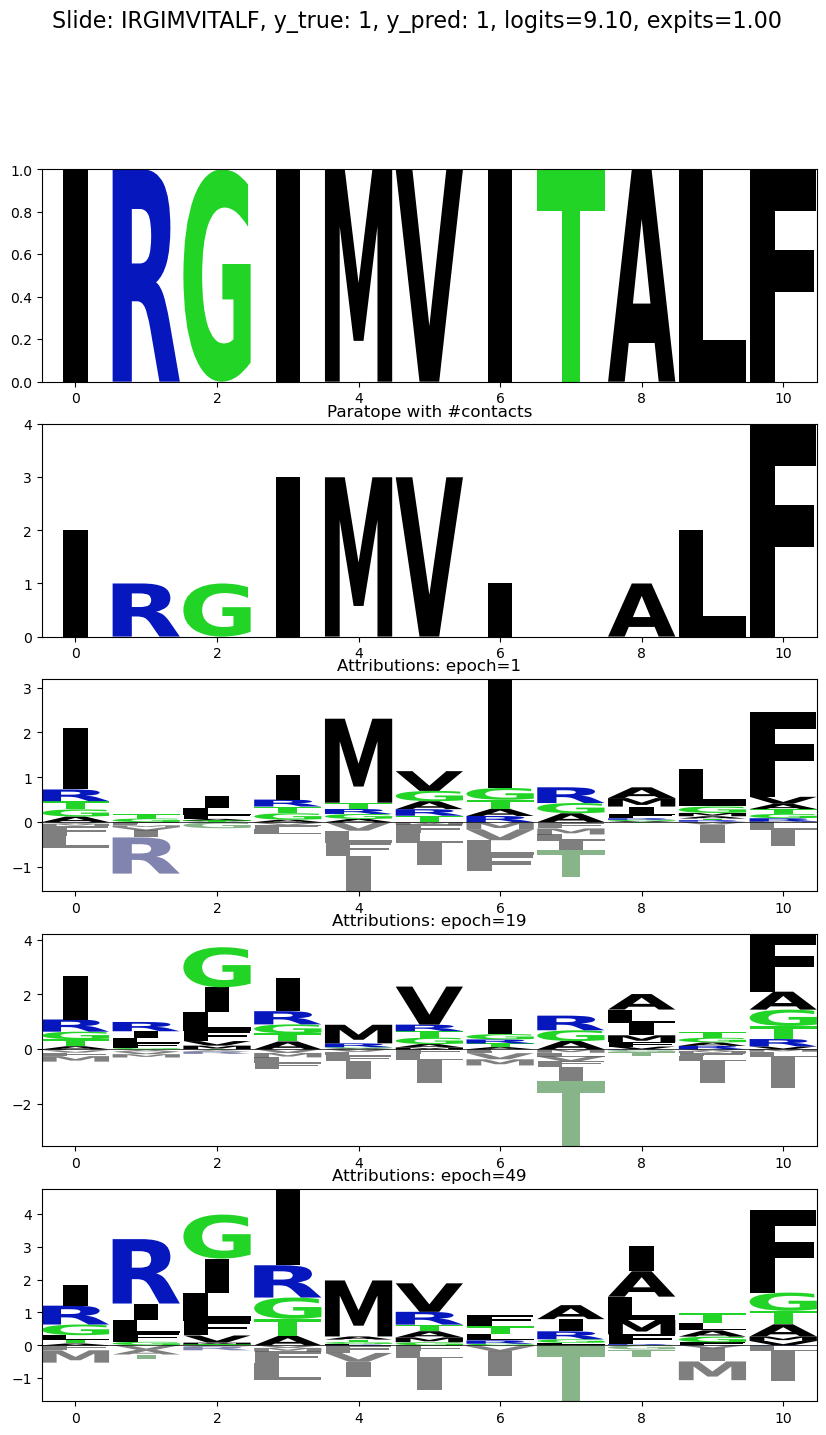

In [26]:
epochs_sel = [1, 19, 49]
df_sel_1_set = df_sel_1[df_sel_1["epoch"].isin(epochs_sel)]

fig, axs = plt.subplots(5, 1, figsize=(10, 16))
row_sel_1_idx_1 = df_sel_1_set.iloc[0]
fig.suptitle(
    f"Slide: {row_sel_1_idx_1['slide']}, y_true: {row_sel_1_idx_1['y_true']}, y_pred: {int(row_sel_1_idx_1['y_pred'])}, "
    f"logits={float(row_sel_1_idx_1['logits']):0.2f}, expits={float(row_sel_1_idx_1['expits']):0.2f}",
    fontsize=16
)

visualisations.plot_logo(
    pd.DataFrame(
        row_sel_1_idx_1["enc"].numpy().reshape((-1, 20)), 
        columns=config.AMINOACID_ALPHABET
        ),
    ax=axs[0],
)

## Paratope
visualisations.plot_logo(
    pd.DataFrame(
        preprocessing.onehot_encode_deg_paratope(row_sel_1_idx_1["agregatesABParatope"]).reshape((-1, 20)), 
        columns=config.AMINOACID_ALPHABET
        ),
    ax=axs[1],
)
axs[1].set_title("Paratope with #contacts")

for i, epoch in enumerate(epochs_sel):
    print(epoch)
    plot_attribution_report_by_index(i, df_sel_1_set, ax=axs[i+2], title=f"Attributions: {epoch=}")